<a href="https://colab.research.google.com/github/astrophysicsvivien/TaylorFlow/blob/master/Waveform_Speed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install lalsuite pycbc

In [0]:
import tensorflow as tf
#enable Eager execution
tf.enable_eager_execution()

import numpy as np
import matplotlib.pyplot as plt
import time

import pycbc.waveform

In [0]:
#Start Interactive Session
sess = tf.InteractiveSession()

def PN_phases(freq,mTot,eta,phase_order):
    """
    PN phase orders for TaylorF2
    """
    
    #constants in equation
    mtsun = 4.925491025543575903411922162094833998e-6
    piM = tf.multiply(mTot*mtsun,np.pi) # Total mass times pi
    v = tf.pow(tf.multiply(piM,freq),(1/3)) # characteristic velocity of binary
    etasq = tf.pow(eta,2) # square of the symmetric mass ratio
    etacb= tf.pow(eta,3) # cube of the symmetric mass ratio
    gamma = 0.577215664901532 #Euler–Mascheroni constant
    
    #v parameters
    v0 = tf.pow(v,-5)
    v2 = tf.pow(v,2)
    v3 = tf.pow(v,3)
    v4 = tf.pow(v,4)
    v5 = tf.pow(v,5)
    v5log = tf.log(v)
    v6 = tf.pow(v,6)
    v6log = tf.log(4*v)
    v7 = tf.pow(v,7)
    
    #produce PN coeffiecients
    P0 = tf.multiply((3./128),tf.reciprocal(eta))
    P2 = tf.multiply(tf.add(743/84,((11)*eta)),(5/9))
    P3 = (-16*np.pi)
    P4 = tf.multiply(tf.add((3058673/1016064),tf.add(((5429/1008)*eta),(617/144)*etasq)),(10))
    P5 = tf.multiply(tf.add(7729/84,(-13*eta)),(np.pi*5/9))
    Pl5 = tf.multiply(tf.add(7729/84,(-13*eta)),(np.pi*5/3))
    P6 = tf.add(((11583231236531/4694215680)-(640*np.pi*np.pi/3)-(6848*gamma/21)),\
         tf.add(((((-15737765635/3048192)+(2255*np.pi*np.pi/12)))*eta),\
         tf.add(((76055/1728)*etasq),(-127825/1296)*etacb)))
    Pl6 = -(6848/21)
    P7 = tf.multiply(tf.add((77096675/254016),tf.add(((378515/1512)*eta),(-74045/756)*etasq)),(np.pi))

    #Produce full PN terms
    PN0 = tf.multiply(P0,v0)
    PN2 = tf.multiply(P2,v2)
    PN3 = tf.multiply(P3,v3)
    PN4 = tf.multiply(P4,v4)
    PN5 = tf.multiply(tf.add(P5,tf.multiply(Pl5,v5log)),v5)
    PN6 = tf.multiply(tf.add(P6,tf.multiply(Pl6,v6log)),v6)
    PN7 = tf.multiply(P7,v7)
    
    #phases = PN_cnst + PN0(1+PN1*v+PN2*v2+PN3*v3+PN4+PN5+PN6+PN7)
    if phase_order == 7:
        phases = tf.multiply(PN0,(1+PN2+PN3+PN4+PN5+PN6+PN7))
    elif phase_order == 6:
        phases = tf.multiply(PN0,(1+PN2+PN3+PN4+PN5+PN6))
    elif phase_order == 5:
        phases = tf.multiply(PN0,(1+PN2+PN3+PN4+PN5))
    elif phase_order == 4:
        phases = tf.multiply(PN0,(1+PN2+PN3+PN4)) 
    elif phase_order == 3:
        phases = tf.multiply(PN0,(1+PN2+PN3))
    elif phase_order == 2:
        phases = tf.multiply(PN0,(1+PN2))
    elif phase_order == 1:
        phases = PN0
    else:
        phases = PN0
        
    return phases
                         
def PN_amplitude(freq,ChirpMass,LuminosityDistance):
    """
    Amplitude at 0PN order
    
    """
    #returns the amplitude of the 0PN waveform
    #arguments are chirp mass, luminosity distance and frequencies
                         
    term1 = tf.reciprocal(LuminosityDistance/299792458)# divide by factor of c to convert to units of time
    term2 = tf.multiply(np.sqrt(5/24)*(np.pi**(-2/3)),tf.pow(ChirpMass*4.92549102554e-6,(5/6))) #times by mtsol to get units of time
    term3 = tf.pow(freq,(-7/6))
                         
    return tf.multiply(term1,tf.multiply(term2,term3))
                         
def taylorf2(mass1,mass2,frequencies=None,LuminosityDistance=1.,f_low=10.,
               df=1./512,f_high=1600.,phase_order=0):
    """
    TaylorFlow Main Function
    
    """
                         
    #Define variable and constants in TensorFlow variables and constants   
    #Masses and frequencies are required inputs
    mass1 = tf.constant(mass1,name="mass1",dtype=tf.float32)
    mass2 = tf.constant(mass2,name="mass2",dtype=tf.float32)
    
    #get total mass,chirp mass and symetric mass ratio for use later in function
    M = tf.add(mass1,mass2)
    eta = tf.divide(tf.multiply(mass1,mass2),tf.pow(M,2))
    ChirpMass = tf.multiply(M,tf.pow(eta,(3/5))) #Chirp mass is given by M*(eta^3/5)   
    
    #define fISCO
    f_ISO = 1/(6.**1.5*np.pi*(M)*4.92549102554e-6) #frequency of innermost stable circular orbit (SI units)
    
    #define frequencies
    if frequencies is None:
        f = tf.range(1.,f_ISO,df)
        frequencies = tf.Variable(f,name= "frequencies",dtype= tf.float32)
    else: 
        frequencies[0] = 1
        frequencies = tf.Variable(frequencies,name= "frequencies",dtype= tf.float32)
            
    #other constants                     
    L_D =  tf.constant((3.086e+22*LuminosityDistance),name="LuminosityDistance",dtype=tf.float32) 
    
    #get phases at PN order
    phase = PN_phases(frequencies, M, eta, phase_order)
    
    #get restricted amplitude
    amp = PN_amplitude(frequencies,ChirpMass,L_D)
    
    #set amplitude to zero where the waveform results are unphysical/unwanted
    cond1 = frequencies<f_low #below f_low
    ind1 = tf.where(cond1)
    cond2 = frequencies>f_ISO #above fISCO
    ind2 = tf.where(cond2)
    amp = tf.scatter_update(tf.Variable(amp), ind1, tf.constant(0.))
    amp = tf.scatter_update(tf.Variable(amp), ind2, tf.constant(0.))
    
    #Calculte waveform
    iphase = tf.multiply(tf.complex(0.,1.),tf.complex(phase-(np.pi/4)+np.pi,0.))
    waveform = tf.multiply(tf.complex(amp,0.),tf.exp(iphase))
      
    return frequencies, waveform

In [0]:
def pyPN_phases(freq,mTot,eta,phase_order):
    "produce phases at 0PN order"
    
    #constants in equation
    mtsun = 4.925491025543575903411922162094833998e-6
    piM = mTot*np.pi*mtsun # pi multiplyed by total mass in seconds
    v = (piM*freq)**(1/3) #Characteristic Velocity of Binary
    etasq = eta*eta # square of the symmetric mass ratio
    etacb= eta*eta*eta # cube of the symmetric mass ratio
    gamma = 0.577215664901532 #Euler–Mascheroni constant
    theta = -11831./9240.
    lambdaa = -1987./3080.0
    
    
    #Generate V terms
    V0 = v**(-5)
    V2 = v**2
    V3 = v*V2
    V4 = v*V3
    V5 = v*V4
    Vlog5 = np.log(v)
    V6 = v*V5
    Vlog6 = np.log(4*v)
    V7 = v*V6
    
    # generate phase coefficients
    P0 = (3/128)*(1/eta)
    P2 = (743/84+(11*eta))*(5/9)
    P3 = (-16*np.pi)
    P4 = 10*((3058673/1016064)+((5429/1008)*eta)+((617/144)*etasq))
    P5 = 5.0/9.0 * (7729.0/84.0 - 13.0 * eta) * np.pi 
    Pl5 = 5.0/3.0 * (7729.0/84.0 - 13.0 * eta) * np.pi 
    P6 = (11583.231236531/4.694215680 - 640.0/3.0 * np.pi * np.pi- \
            6848.0/21.0*gamma) + \
            eta * (-15335.597827/3.048192 + 2255./12. * np.pi * \
            np.pi - 1760./3.*theta +12320./9.*lambdaa) + \
            etasq * 76055.0/1728.0 - \
            etacb*  127825.0/1296.0
    Pl6 = -6848.0/21.0
    P7 = np.pi*((77096675/254016)+((378515/1512)*eta)+((-74045/756)*etasq))
    
    #Generetate PN terms
    
    PN0 = P0*V0
    PN2 = P2*V2
    PN3 = P3*V3
    PN4 = P4*V4
    PN5 = (P5+Pl5*Vlog5)*V5
    PN6 = (P6+Pl6*Vlog6)*V6
    PN7 = P7*V7
    
    #phases = PN_cnst + PN0*(1+PN2+PN3+PN4+PN5+PN6+PN7)
    if phase_order == 7:
        phases = PN0*(1+PN2+PN3+PN4+PN5+PN6+PN7)
    elif phase_order == 6:
        phases = PN0*(1+PN2+PN3+PN4+PN5+PN6)
    elif phase_order == 5:
        phases = PN0*(1+PN2+PN3+PN4+PN5)
    elif phase_order == 4:
        phases = PN0*(1+PN2+PN3+PN4) 
    elif phase_order == 3:
        phases = PN0*(1+PN2+PN3)
    elif phase_order == 2:
        phases = PN0*(1+PN2)
    elif phase_order == 1:
        phases = PN0
    else:
        phases = PN0
    
    return phases

def pyPN_amplitude(freq,ChirpMass,LuminosityDistance):
    "produce amplitude at 0PN order"
    
    return (299792458/LuminosityDistance)*(((5/24)**0.5)*(np.pi**(-2/3)))*((ChirpMass*4.92549102554e-6)**(5/6))*(freq**(-7/6))

def pytaylorf2(mass1,mass2,frequencies=None,LuminosityDistance=1.,f_low=10.,
               df=1./512, f_high=1600., phase_order=0):
    
    #genrate characteristic masses
    M = mass1+mass2
    eta = (mass1*mass2)/(M**2)
    ChirpMass = M*(eta**(3/5)) #Chirp mass is given by M*(eta^3/5)
    
    #define frequencies
    f_ISO = 1/(6.**1.5*np.pi*(M)*4.92549102554e-6) #frequency of innermost stable circular orbit (SI units)
    if frequencies is None:
        f = np.arange(f_low,f_ISO,df)
        freq = f
    else: 
        frequencies[0] = 1
        freq = frequencies 
        
    #Luminosity distance in SI Units
    L_D =  3.086e+22*LuminosityDistance
    
    #Evaluate phases and amplitudes across frequencies
    phase = pyPN_phases(freq,M,eta,phase_order)
    amp = pyPN_amplitude(freq,ChirpMass,L_D)
    
    #set amplitude to zero where the waveform results are unphysical or unwanted
    np.array(amp)[np.array(np.argwhere(freq<f_low))] = 0.
    np.array(amp)[np.array(np.argwhere(freq>f_ISO))] = 0.
    
    #Produce waveform
    waveform = amp*np.exp(1j*(phase+(3/4)*np.pi))
    
    return freq, waveform

In [0]:
m1 = 1.4
m2 = 1.4
flow = 10
fhigh = 2000
df = 1./512

In [6]:
PN_order = 7

speed_tests = 1
pycbc_speeds = np.zeros(speed_tests)
tf_speeds = np.zeros(speed_tests)
tfcpu_speeds = np.zeros(speed_tests)
tfgpu_speeds = np.zeros(speed_tests)
python_speeds = np.zeros(speed_tests)

for speed in range(speed_tests):
    pycbc_start = time.time()
    pycbc_waveform, hc1 = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                                 mass1=m1, mass2=m2,
                                 f_lower=flow,
                                 f_high = fhigh,
                                 delta_f=df,
                                 phase_order=PN_order,
                                 amplitude_order=0)
    pycbc_end = time.time()
    pycbc_speeds[speed] = pycbc_end-pycbc_start
    #####
    tf_start = time.time()
    freq,tf_waveform = taylorf2(m1,m2,
                                df = df,
                                f_low = flow,
                                f_high = fhigh,
                                phase_order = PN_order)
    tf_end = time.time()
    tf_speeds[speed] = tf_end-tf_start
    #####
    tfcpu_start = time.time()
    with tf.device('/cpu:0'):
        freq,tf_waveform = taylorf2(m1,m2,
                                df = df,
                                f_low = flow,
                                f_high = fhigh,
                                phase_order = PN_order)

    tfcpu_end = time.time()
    tfcpu_speeds[speed] = tfcpu_end-tfcpu_start
    #####
    tfgpu_start = time.time()
    with tf.device('/gpu:0'):
        freq,tf_waveform = taylorf2(m1,m2,
                                df = df,
                                f_low = flow,
                                f_high = fhigh,
                                phase_order = PN_order)

    tfgpu_end = time.time()
    tfgpu_speeds[speed] = tfgpu_end-tfgpu_start
    #####
    py_start = time.time()
    pyfreq,pywaveform = pytaylorf2(m1,m2,
                                df = df,
                                f_low = flow,
                                f_high = fhigh,
                                phase_order = PN_order)
    py_end = time.time()
    python_speeds[speed] = py_end-py_start

print('pycbc time is %g' %(pycbc_end-pycbc_start))
print('TaylorFlow CPU/GPU time is %g' %(tf_end-tf_start))
print('TaylorFlow CPU time is %g' %(tfcpu_end-tfcpu_start))
print('TaylorFlow GPU time is %g' %(tfgpu_end-tfgpu_start))
print('python time is %g' %(py_end-py_start))


W0820 09:00:10.200972 139628644591488 deprecation.py:323] From <ipython-input-3-f6292a7525dd>:120: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


pycbc time is 0.150683
TaylorFlow CPU/GPU time is 0.502088
TaylorFlow CPU time is 0.161334
TaylorFlow GPU time is 0.0243897
python time is 0.30405


total time is 299.95


/usr/local/lib/python3.6/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


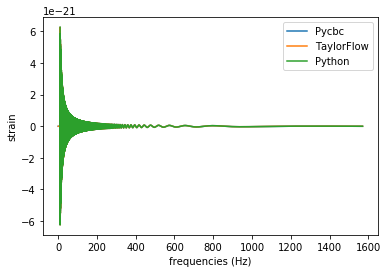

In [7]:
PN_order = 7

total_start = time.time()

speed_tests = 500
pycbc_speeds = np.zeros(speed_tests)
tf_speeds = np.zeros(speed_tests)
tfcpu_speeds = np.zeros(speed_tests)
tfgpu_speeds = np.zeros(speed_tests)
python_speeds = np.zeros(speed_tests)

for speed in range(speed_tests):
    pycbc_start = time.time()
    pycbc_waveform, hc1 = pycbc.waveform.get_fd_waveform(approximant="TaylorF2",
                                 mass1=m1, mass2=m2,
                                 f_lower=flow,
                                 f_high = fhigh,
                                 delta_f=df,
                                 phase_order=PN_order,
                                 amplitude_order=0)
    pycbc_end = time.time()
    pycbc_speeds[speed] = pycbc_end-pycbc_start
    #####
    tf_start = time.time()
    freq,tf_waveform = taylorf2(m1,m2,
                                df = df,
                                f_low = flow,
                                f_high = fhigh,
                                phase_order = PN_order)
    tf_end = time.time()
    tf_speeds[speed] = tf_end-tf_start
    #####
    tfcpu_start = time.time()
    with tf.device('/cpu:0'):
        freq,tf_waveform = taylorf2(m1,m2,
                                df = df,
                                f_low = flow,
                                f_high = fhigh,
                                phase_order = PN_order)

    tfcpu_end = time.time()
    tfcpu_speeds[speed] = tfcpu_end-tfcpu_start
    #####
    tfgpu_start = time.time()
    with tf.device('/gpu:0'):
        freq,tf_waveform = taylorf2(m1,m2,
                                df = df,
                                f_low = flow,
                                f_high = fhigh,
                                phase_order = PN_order)

    tfgpu_end = time.time()
    tfgpu_speeds[speed] = tfgpu_end-tfgpu_start
    #####
    py_start = time.time()
    pyfreq,pywaveform = pytaylorf2(m1,m2,
                                df = df,
                                f_low = flow,
                                f_high = fhigh,
                                phase_order = PN_order)
    py_end = time.time()
    python_speeds[speed] = py_end-py_start
total_stop = time.time()

print('total time is %g' %(total_stop-total_start))

plt.figure()
plt.plot(pycbc_waveform.sample_frequencies,pycbc_waveform)
plt.plot(freq.numpy(),tf_waveform)
plt.plot(pyfreq[:],pywaveform[:])
plt.ylabel('strain')
plt.xlabel('frequencies (Hz)')
plt.legend(['Pycbc','TaylorFlow','Python'])



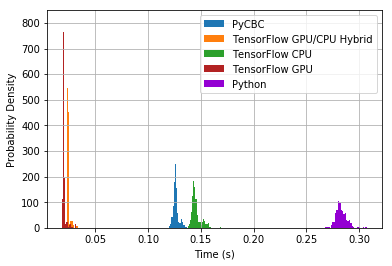

In [15]:
plt.figure()
bins = 30
plt.hist(pycbc_speeds[:],bins,density=True)
plt.hist(tf_speeds[:],bins,density=True)
plt.hist(tfcpu_speeds[:],bins,density=True)
plt.hist(tfgpu_speeds[:],bins,density=True,color='firebrick')
plt.hist(python_speeds[:],bins,density=True,color='darkviolet')

plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.legend(['PyCBC','TensorFlow GPU/CPU Hybrid','TensorFlow CPU','TensorFlow GPU','Python'])
plt.grid()

speed histograms for 500 waveforms per method generated at m1=m2=1.4mSol (3.5PN)

mean = 0.126459
std = 0.002934


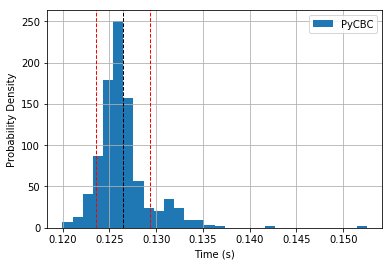

In [29]:
plt.figure()
plt.hist(pycbc_speeds[:],30,density=True)
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.legend(['PyCBC'])
plt.grid()
plt.axvline(pycbc_speeds.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(pycbc_speeds.mean()+pycbc_speeds.std(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(pycbc_speeds.mean()-pycbc_speeds.std(), color='r', linestyle='dashed', linewidth=1)

print('mean = %f' %(pycbc_speeds.mean()))
print('std = %f'%(pycbc_speeds.std()))

mean = 0.024621
std = 0.001488


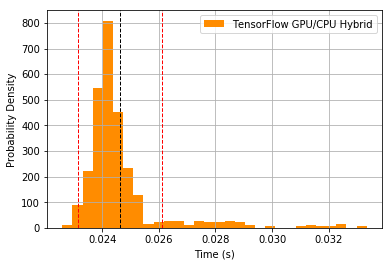

In [23]:
plt.figure()
plt.hist(tf_speeds[:],30,density=True,color='darkorange')
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.legend(['TensorFlow GPU/CPU Hybrid'])
plt.grid()
plt.axvline(tf_speeds.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(tf_speeds.mean()+tf_speeds.std(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(tf_speeds.mean()-tf_speeds.std(), color='r', linestyle='dashed', linewidth=1)

print('mean = %f' %(tf_speeds.mean()))
print('std = %f'%(tf_speeds.std()))

mean = 0.145375
std = 0.004275


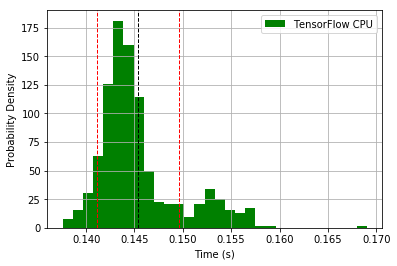

In [24]:
plt.figure()
plt.hist(tfcpu_speeds[:],30,density=True,color='g')
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.legend(['TensorFlow CPU'])
plt.grid()
plt.axvline(tfcpu_speeds.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(tfcpu_speeds.mean()+tfcpu_speeds.std(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(tfcpu_speeds.mean()-tfcpu_speeds.std(), color='r', linestyle='dashed', linewidth=1)

print('mean = %f' %(tfcpu_speeds.mean()))
print('std = %f'%(tfcpu_speeds.std()))

mean = 0.020340
std = 0.001667


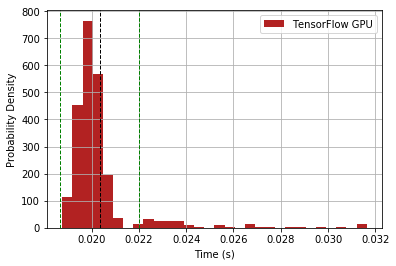

In [26]:
plt.figure()
plt.hist(tfgpu_speeds[:],30,density=True,color='firebrick')
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.legend(['TensorFlow GPU'])
plt.grid()
plt.axvline(tfgpu_speeds.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(tfgpu_speeds.mean()+tfgpu_speeds.std(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(tfgpu_speeds.mean()-tfgpu_speeds.std(), color='g', linestyle='dashed', linewidth=1)

print('mean = %f' %(tfgpu_speeds.mean()))
print('std = %f'%(tfgpu_speeds.std()))

mean = 0.283072
std = 0.005072


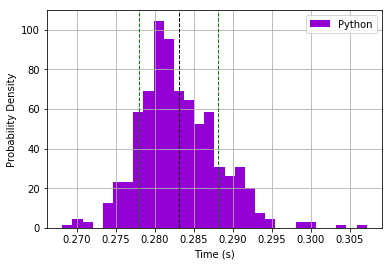

In [27]:
plt.figure()
plt.hist(python_speeds[:],30,density=True,color='darkviolet')
plt.xlabel('Time (s)')
plt.ylabel('Probability Density')
plt.legend(['Python'])
plt.grid()
plt.axvline(python_speeds.mean(), color='k', linestyle='dashed', linewidth=1)
plt.axvline(python_speeds.mean()+python_speeds.std(), color='g', linestyle='dashed', linewidth=1)
plt.axvline(python_speeds.mean()-python_speeds.std(), color='g', linestyle='dashed', linewidth=1)

print('mean = %f' %(python_speeds.mean()))
print('std = %f'%(python_speeds.std()))

In [21]:
print(pycbc_waveform.sample_frequencies[512:])
print(freq.numpy())
print(pycbc_waveform.sample_frequencies[1]-pycbc_waveform.sample_frequencies[0])
print(freq.numpy()[1]-freq.numpy()[0])
print(len(pycbc_waveform.sample_frequencies)-len(freq.numpy()))

[1.00000000e+00 1.00195312e+00 1.00390625e+00 ... 1.57041406e+03
 1.57041602e+03 1.57041797e+03]
[1.0000000e+00 1.0019531e+00 1.0039062e+00 ... 1.5704141e+03 1.5704160e+03
 1.5704180e+03]
0.001953125
0.001953125
512
